In [156]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.utils import resample

In [134]:
n = 50
p = 6
nx = 5
alpha = 0.05

x = np.concatenate([np.ones((n, 1)), np.random.uniform(-1, 1, (n, nx))], axis=1)
y = np.apply_along_axis(
    lambda x: np.random.normal(
        np.array([2, 3, -2, 1, 1, -1]) @ x, 1.5
    ),
    1,
    x
)

In [135]:
def r2(x, y):
    f = x.T @ x
    f_inv = np.linalg.inv(f)
    beta = f_inv @ x.T @ y
    rss = np.sum((y - x @ beta) ** 2)
    tss = np.sum((y - np.mean(y)) ** 2)
    return float((tss - rss) / tss)

# Пункт А

Мультиколлинеарность

In [136]:
for i in range(nx):
    mask = [0, 0, 0, 0, 0, 0]
    mask[i + 1] = 1
    mask = np.array(mask, dtype=np.bool_)
    print(f"{i + 1}: R^2 = {r2(x[:, ~mask], x[:, mask])}")

1: R^2 = 0.012549325110496666
2: R^2 = 0.09022444527024763
3: R^2 = 0.041381612500100536
4: R^2 = 0.06698441694837119
5: R^2 = 0.057336732630703324


т.к все $ R^{2} < 0.7 $, то мультиколлинеарности нет

# Пункт B

In [137]:
from scipy.stats import t

In [138]:
F = x.T @ x
F_inv = np.linalg.inv(F)
beta = F_inv @ x.T @ y
print(f"{beta = }", end="\n\n")

rss = float(np.sum((y - x @ beta) ** 2))
print(f"{rss = }", end="\n\n")
for i in range(p):
    delta = float(beta[i] / np.sqrt(rss * F_inv[i, i]) * np.sqrt(n - p))
    p_val = float(2 * t.sf(abs(delta), n - p))
    print(f"beta{i}: {delta = } f_inv[i, i] = {float(F_inv[i, i])} {p_val = }")

beta = array([ 1.9412572 ,  2.74869615, -1.87599059,  1.199763  ,  0.72097973,
       -1.22808496])

rss = 121.01853334842542

beta0: delta = 8.145452416424085 f_inv[i, i] = 0.02065078316112111 p_val = 2.4960949840853276e-10
beta1: delta = 6.443048522792869 f_inv[i, i] = 0.0661715724923107 p_val = 7.523631411645969e-08
beta2: delta = -4.350610008885108 f_inv[i, i] = 0.06760235009748417 p_val = 7.948138977866038e-05
beta3: delta = 2.8081969283531283 f_inv[i, i] = 0.06636461830578354 p_val = 0.0074010446633569205
beta4: delta = 1.6755385100610904 f_inv[i, i] = 0.06731906504810257 p_val = 0.1009220244173141
beta5: delta = -2.931076123672162 f_inv[i, i] = 0.06382685116887758 p_val = 0.00534021554353816


## beta 4 - не значим

# Пункт С

коэффицент детерминации

In [139]:
tss = float(np.sum((y - np.mean(y)) ** 2))
r2 = float((tss - rss) / tss)
print(f"{rss = } {tss = } R^2 = {r2}")
delta = float(((tss - rss) * (n - p)) / (rss * (p - 1)))
p_val = float(st.f.sf(delta, p - 1, n - p))
print(f"{delta = } {p_val = }")

rss = 121.01853334842542 tss = 322.980658478682 R^2 = 0.6253071811839992
delta = 14.685905141729949 p_val = 1.810438848761455e-08


## Регрессия значима

# Пункт D

доверительный интервал 

In [140]:
x0 = np.array([1, 0, 0, 0, 0, 0])
y_estim = x0 @ beta
delta = float(st.t.isf(0.025, n - p) * np.sqrt((1 + x0 @ F_inv @ x0.T) * (rss / (n - p))))
print(f"{delta = } {y_estim = } I = ({y_estim - delta}, {y_estim + delta})")

delta = 3.376699836961502 y_estim = 1.9412571961809215 I = (-1.4354426407805807, 5.317957033142424)


# Пункт E

In [141]:
def count_inversions(arr):
    inv = 0
    for i in range(len(arr)):
        for j in range(i + 1, len(arr)):
            if arr[i] > arr[j]:
                inv += 1
    return inv

e = y - x @ beta
delta = float((count_inversions(e) - n * (n - 1) / 4) / np.sqrt(n ** 3 / 36))
p_val = 2 * st.norm.sf(abs(delta))
print(f"{delta = } {p_val = }")

delta = -1.1794541110191612 p_val = 0.23821739921276963


Следовательно, нет оснований отвергать гипотезу случайности

# Пункт F

In [142]:
from collections.abc import Callable


def parametric_bootstrap(
    data: np.ndarray,
    statistic: Callable[[np.ndarray], float],
    prob_model: Callable[[int], np.ndarray],
    n_resamples: int = 10_000,
) -> np.ndarray:
    bootstrap_data = np.ndarray((n_resamples, ), dtype=np.float32)

    for i in range(n_resamples):
        resample = prob_model(n)
        bootstrap_data[i] = statistic(resample)
    
    bootstrap_data.sort()

    return bootstrap_data


def statistic(data):
    data = np.sort(data)

    mean = 0
    std = np.std(data, ddof=1)

    ecdf = np.append([0], st.ecdf(data).cdf.probabilities)
    cdf = st.norm.cdf(data, loc=mean, scale=std)
    delta = np.sqrt(n) * np.max(np.abs(
        np.append(
            cdf - ecdf[:len(ecdf) - 1],
            cdf - ecdf[1:]
        )
    ))

    return delta


e = y - x @ beta
mean = 0
std = np.std(e, ddof=1)
n_resamples = 50_000
bootstrap = parametric_bootstrap(
    e,
    statistic,
    lambda n: np.random.normal(mean, std, n),
    n_resamples=n_resamples,
)

ecdf = np.append([0], st.ecdf(e).cdf.probabilities)
cdf = st.norm.cdf(np.sort(e), loc=mean, scale=std)
kolmogorov_delta = np.sqrt(n) * np.max(np.abs(
    np.append(
        cdf - ecdf[:len(ecdf) - 1],
        cdf - ecdf[1:]
    )
))
kolmogorov_delta = float(kolmogorov_delta)

kolmogorov_pval = np.count_nonzero(bootstrap >= kolmogorov_delta) / n_resamples

print(
    f"{kolmogorov_delta = }",
    f"{kolmogorov_pval = }",
    sep="\n"
)

kolmogorov_delta = 0.6478101158143359
kolmogorov_pval = 0.70126


Следовательно, нет оснований отвергать гипотезу нормальности

# пункт G

Text(0.5, 1.0, 'y')

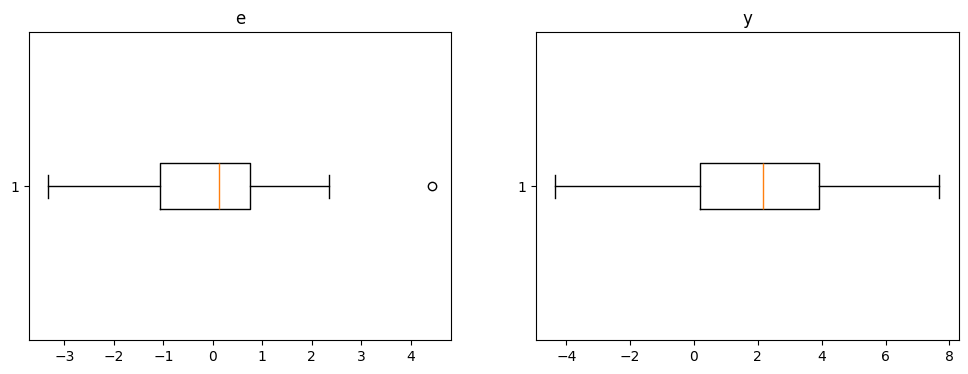

In [143]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].boxplot(e, vert=False)
ax[0].set_title('e')

ax[1].boxplot(y, vert=False)
ax[1].set_title('y')

# Пункт H

In [151]:
cvss = []
for i in range(n):
    mask = np.zeros(50, dtype=np.bool_)
    mask[i] = 1
    x_train, x_test = x[~mask], x[i]
    y_train, y_test = y[~mask], y[i]

    f = x_train.T @ x_train
    f_inv = np.linalg.inv(f)

    beta = f_inv @ x_train.T @ y_train
    cvss.append((y_test - beta @ x_test) ** 2)

r2_cv = float((tss - np.sum(cvss)) / tss)
print(f"R^2_CV = {r2_cv}")

R^2_CV = 0.5244996482470252


# Пункт I

In [152]:
l = 5
x0 = np.concatenate([np.ones(1), np.random.uniform(-1, 1, 5)])
y0 = np.array([np.random.normal(
        np.array([2, 3, -2, 1, 1, -1]) @ x0, 1.5
    ) for _ in range(l)])
delta = float(rss / (n - p) / np.std(y0, ddof=1) ** 2)
p_val = float(st.f.sf(delta, n - p, l - 1) + st.f.cdf(-delta, n - p, l - 1))
print(f"{delta = } {p_val = }")

delta = 0.7726604956693562 p_val = 0.713040549732161


## Регрессия адекватна

# Пункт J

In [159]:
x_short = x[:, [True, True, True, True, False, True]]
F = x_short.T @ x_short
F_inv = np.linalg.inv(F)
beta_short = F_inv @ x_short.T @ y
print(f"{beta_short = }", end="\n\n")

rss_short = float(np.sum((y - x_short @ beta_short) ** 2))
print(f"{rss_short = }", end="\n\n")
for i in range(p - 1):
    delta = float(beta_short[i] / np.sqrt(rss_short * F_inv[i, i]) * np.sqrt(n - p - 1))
    p_val = float(st.t.sf(delta, n - p - 1))
    print(f"beta_short{i}: {delta = } f_inv[i, i] = {float(F_inv[i, i])} {p_val = }")

beta_short = array([ 1.96682023,  2.71377943, -1.71167406,  1.1250044 , -1.26110117])

rss_short = 128.74014644405722

beta_short0: delta = 7.926205841530857 f_inv[i, i] = 0.02056615463664659 p_val = 3.016088770831133e-10
beta_short1: delta = 6.104284966630128 f_inv[i, i] = 0.06601368095638149 p_val = 1.289193246326471e-07
beta_short2: delta = -3.907059603937827 f_inv[i, i] = 0.06410568131516844 p_val = 0.9998371403235543
beta_short3: delta = 2.537724275720555 f_inv[i, i] = 0.06564082553891652 p_val = 0.007431872559445236
beta_short4: delta = -2.8880603400610645 f_inv[i, i] = 0.06368567984600747 p_val = 0.9969770087194957


Следовательно, все коэффициенты кроме beta 5 и beta 3 значимы

In [160]:
r2_short = float((tss - rss_short) / tss)
print(f"{rss_short = } {tss = } R^2 = {r2_short}")
delta = float(((tss - rss_short) * (n - p - 1)) / (rss_short * (p - 2)))
p_val = float(st.f.sf(delta, p - 2, n - p - 1))
print(f"{delta = } {p_val = }")

rss_short = 128.74014644405722 tss = 322.980658478682 R^2 = 0.6013998266940973
delta = 16.21938114913963 p_val = 3.593436762477103e-08


Следовательно, вся регрессия значима

In [161]:
delta = float((rss_short - rss) / (rss / (n - p)))
p_val = float(st.f.sf(delta, 1, n - p))
print(f"{delta = } {p_val = }")

delta = 2.80742929869774 p_val = 0.10092202441731389


Следовательно, короткая регрессия лучше длинной

# Пункт K

In [162]:
def linear_regression(x, y):
    f = x.T @ x
    f_inv = np.linalg.inv(f)
    beta = f_inv @ x.T @ y

    return f_inv, beta
def calc_r2(x, y):
    _, beta = linear_regression(x, y)
    rss = np.sum((y - x @ beta) ** 2)
    tss = np.sum((y - np.mean(y)) ** 2)
    return float((tss - rss) / tss)

In [158]:
h = r2 - r2_short
def statistic(sample):
    phi = sample[:, :len(sample[0]) - 1]
    y = sample[:, -1]
    phi_short = phi[:, [True, True, True, True, True, False]]

    return (calc_r2(phi, y) - calc_r2(phi_short, y)) - h


data = np.concatenate([x, y.reshape(-1, 1)], axis=1)
res = []
n_resamples = 1000
for _ in range(n_resamples):
    sample = resample(data, replace=True, n_samples=n)
    res.append(statistic(sample))
res = sorted(res)
I = (h - res[n_resamples - 1], h - res[int(alpha * n_resamples) - 1])
I

(-0.2024100860689168, 0.03383261316788855)